# transformer 

## 项目介绍
====

我们将训练一个 **Transformer** 模型 用于将葡萄牙语翻译成英语。在此之前，建议先了解有关[文本生成](https://www.tensorflow.org/tutorials/text/text_generation?hl=zh-cn)和[注意力机制](https://www.tensorflow.org/tutorials/text/nmt_with_attention?hl=zh-cn)的相关内容。

**Transformer** 模型的核心思想是**自注意力机制**（self-attention）——能注意输入序列的不同位置以计算该序列的表示的能力。**Transformer** 创建了多层**自注意力层**（self-attetion layers）组成的堆栈，下文的按比缩放的点积注意力（Scaled dot product attention）和多头注意力（Multi-head attention）部分对此进行了说明。

Transformer中抛弃了传统的CNN和RNN，整个网络结构完全是由Attention机制组成。 作者采用Attention机制的原因是考虑到RNN（或者LSTM，GRU等）的计算限制为是顺序的，也就是说RNN相关算法只能从左向右依次计算或者从右向左依次计算，这种机制带来了两个问题：

时间片 tt 的计算依赖 t-1t−1 时刻的计算结果，这样限制了模型的并行能力

顺序计算的过程中信息会丢失，尽管LSTM等门机制的结构一定程度上缓解了长期依赖的问题，但是对于特别长期的依赖现象，LSTM依旧无能为力。

Transformer的提出解决了上面两个问题：

首先它使用了Attention机制，将序列中的任意两个位置之间的距离缩小为一个常量；

其次它不是类似RNN的顺序结构，因此具有更好的并行性，符合现有的GPU框架。


该架构的缺点是：

*   对于时间序列，一个单位时间的输出是从整个历史记录计算的，而非仅从输入和当前的隐含状态计算得到。这可能效率较低。
*   如果输入确实有时间 / 空间的关系，像文本，则必须加入一些位置编码，否则模型将有效地看到一堆单词。

训练完模型后，您将能输入葡萄牙语句子，得到其英文翻译。

![](https://tensorflow.google.cn/images/tutorials/transformer/attention_map_portuguese.png?hl=zh-cn)



Transformer模型在论文[《Attention Is All You Need》](https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf)中被提出，利用Attention，去掉RNN。这篇论文的题目想说的是：你只需要用到Attention机制，完全不需要再用到RNN，就能解决很多问题。Transformer没有用到RNN，而且它的效果很好。

Transformer模型总体的样子如下图所示：总体来说，还是和Encoder-Decoder模型有些相似，左边是Encoder部分，右边是Decoder部分。
![](https://luweikxy.github.io/machine-learning-notes/natural-language-processing/self-attention-and-transformer/attention-is-all-you-need/pic/transformer-model-architecture.jpg)

Encoder：输入是单词的Embedding，再加上位置编码，然后进入一个统一的结构，这个结构可以循环很多次（N次），也就是说有很多层（N层）。每一层又可以分成Attention层和全连接层，在每一层中，再额外加了一些处理，比如Skip Connection，做跳跃连接，然后还加了Normalization层。其实它本身的模型还是很简单的。

Decoder：第一次输入是前缀信息，之后的就是上一次产出的Embedding，加入位置编码，然后进入一个可以重复很多次的模块。该模块可以分成三块来看，第一块也是Attention层，第二块是cross Attention，不是Self-Attention，第三块是全连接层。也用了跳跃连接和Normalization。

输出：最后的输出要通过Linear层（全连接层），再通过softmax做预测。



## 导入库、数据集、数据处理

In [1]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf


Bad key "text.kerning_factor" on line 4 in
C:\Users\xukaihui\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


使用 TFDS 来导入 葡萄牙语-英语翻译数据集，该数据集来自于 TED 演讲开放翻译项目.

该数据集包含来约 50000 条训练样本，1100 条验证样本，以及 2000 条测试样本。

In [2]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']
train_examples

<PrefetchDataset shapes: ((), ()), types: (tf.string, tf.string)>

此时得到的 **train_examples** 和 **val_examples** 的类型都是 **dataset**，所以我们可以用它的 **take** 属性打印其中一个样本：

In [3]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


您不能直接在文本上训练模型。文本需要首先转换为一些数字表示。通常，您将文本转换为 ID 序列，用作嵌入的索引。

Subword tokenizer 教程中演示了一种流行的实现，它构建text.BertTokenizer了为此数据集优化的子词 tokenizer ( ) 并将它们导出到saved_model中。

下载并解压缩并导入saved_model：

In [4]:
model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)

'.\\ted_hrlr_translate_pt_en_converter.zip'

包含两个文本标记器tf.saved_model，一个用于英语，一个用于葡萄牙语。两者都有相同的方法：

In [5]:
tokenizers = tf.saved_model.load(model_name)

In [6]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

该tokenize方法将一批字符串转换为一批填充的令牌 ID。此方法在标记化之前拆分标点符号、小写字母和 unicode 规范化输入。该标准化在这里不可见，因为输入数据已经标准化。

In [7]:
for en in en_examples.numpy():
  print(en.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [8]:
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
  print(row)

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


该detokenize方法尝试将这些 ID 转换回人类可读的文本：

In [9]:
round_trip = tokenizers.en.detokenize(encoded)
for line in round_trip.numpy():
  print(line.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


较低级别的lookup方法将 token ID 转换为 token text：

In [10]:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability', b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage', b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip', b'##ity', b'.', b'[END]'], [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?', b'[END]'], [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for', b'curiosity', b'.', b'[END]']]>

在这里，您可以看到分词器的“子词”方面。单词“searchability”分解为“search ##ability”，单词“serendipity”分解为“s ##ere ##nd ##ip ##ity”

In [11]:
# 对原始文本进行编码
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

In [12]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## 位置编码

因为该模型并不包括任何的循环神经网络，所以此模型中不包括任何的词序信息，而这些信息是非常重要的。

比如一个单词在句子中的位置或排列顺序不同，可能整个句子的意思就发生了偏差。

```
I do not like apple, but I do like banana.
I do like apple, but I do not like banana.

```

上面两句话所使用的的单词完全一样，但是所表达的句意却截然相反。那么，我们需要引入词序信息来区别这两句话的意思。

所以模型添加了位置编码，为模型提供一些关于单词在句子中相对位置的信息。

**Transformer** 模型本身不具备像循环神经网络那样的学习词序信息的能力，所以我们需要主动地将词序信息输入模型。那么，模型原先的输入是不含词序信息的词向量，位置编码需要将词序信息和词向量结合起来形成一种新的表示输入给模型（在编码器和解码器中使用），这样模型就具备了学习词序信息的能力。

计算位置编码的公式如下：  
![](https://img-blog.csdnimg.cn/20200414105057638.png#pic_center)  


其中， pos 是单词的位置索引，设句子长度为 L ，那么 $pos=0,1,...,L−1$。 i 是向量的某一维度，假设词向量维度 $d_{model}=512$ ，那么 $i=0,1,...,255$。

举例来说，假设 $d_{model}=5$，那么在一个样本中：  
第一个单词的位置编码为：  

$$\begin{bmatrix} sin(\frac{0}{10000^{\frac{2\times 0}{5}}}) & cos(\frac{0}{10000^{\frac{2\times 0}{5}}}) & sin(\frac{0}{10000^{\frac{2\times 1}{5}}}) & cos(\frac{0}{10000^{\frac{2\times 1}{5}}}) & sin(\frac{0}{10000^{\frac{2\times 2}{5}}}) \\ \end{bmatrix}$$



第二个单词的位置编码为：



$$\begin{bmatrix} sin(\frac{1}{10000^{\frac{2\times 0}{5}}}) & cos(\frac{1}{10000^{\frac{2\times 0}{5}}}) & sin(\frac{1}{10000^{\frac{2\times 1}{5}}}) & cos(\frac{1}{10000^{\frac{2\times 1}{5}}}) & sin(\frac{1}{10000^{\frac{2\times 2}{5}}}) \\ \end{bmatrix}$$


In [13]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    # np.arange(position)[:, np.newaxis] 增加维度  position * 1，   1 * d_model
    # 计算后可以得到  position * d_model 维度的矩阵
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    
    # 将 sin 应用于数组中的偶数索引（indices）；2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # 将 cos 应用于数组中的奇数索引；2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    # 1 * position * d_model
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)


(1, 50, 512)


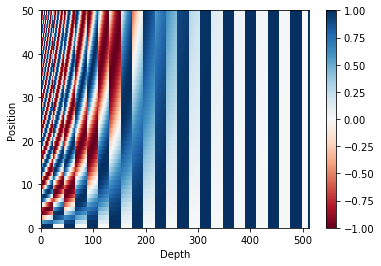

In [14]:
n, d = 50, 512
pos_encoding = positional_encoding(n, d)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 遮挡（Masking）

$\begin{cases}1.padding \ mask \\2.lookahead mask（翻译任务中预测文本时 (decoder 部分))\end{cases}$

### 填充遮挡 （padding mask）

遮挡一批序列中所有的填充标记（即将文本转换到数字向量后标记为零的位置）。这确保了模型不会将填充作为输入。在填充值 0 出现的位置 mask 输出 1，否则输出 0。

当我们在确定 $Max \ length$ 时候，对于不够长的句子肯定要做 $padding$ 但是对于为 0 的那一部分在 $softmax$ 时候会变为 1：  
        回顾 $softmax$ 函数:
$$
\sigma (\mathbf {z} )_{i}= \frac {e^{z_i} } {\sum _{j=1} ^ {K} e^ {z_j} }  
$$

$$ $$

$e^0$ 是 1, 是有值的, 这样的话 $softmax$ 中被 $padding$ 的部分就参与了运算, 就等于是让无效的部分参与了运算, 这样肯定不对, 这时就需要做一个 $mask$ 让这些无效区域不参与运算, 我们一般给无效区域加一个很大的负数的偏置, 也就是:

$$z_{illegal}=z_{illegal}+bias_{illegal}$$  
$$bias_{illegal}\to-\infty$$  
$$e^{z_{illegal}}\to0$$

In [15]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # 添加额外的维度来填充
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [16]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

### lookahead mask

前瞻遮挡用于遮挡未来的信息，在训练和预测阶段使用。这意味着，如果要预测第三个词，将仅使用第一个和第二个词。与此类似，预测第四个词，仅使用第一个，第二个和第三个词，依此类推。 举例来说：  
![](https://img-blog.csdnimg.cn/20200414110922673.png#pic_center)  
比如说输入是一句话 “I have a dream” 总共 4 个单词， 这里就会形成一张 4x4 的注意力机制（在下面介绍）的图。

I 作为第一个单词，只能有和 I 自己的 attention。have 作为第二个单词，有和 I, have 两个 attention。 a 作为第三个单词，有和 I, have, a 前面三个单词的 attention。到了最后一个单词 dream 的时候，才有对整个句子 4 个单词的 attention。


这里的 **tf.linalg.band_part(input, num_lower, num_upper)** 函数可以返回一个三角矩阵，**input** 是输入的矩阵；**num_lower** 是下三角中保留的行数；**num_upper** 是上三角中保留的行数，当 **num_lower** 或 **num_upper** 等于 -1 时，表示下三角或上三角全部保留。

In [17]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [18]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
print(x)
temp

tf.Tensor([[0.7363788 0.1665951 0.8911698]], shape=(1, 3), dtype=float32)


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Muti-head attention

在前面的基础上，我们已经有了词向量矩阵和位置嵌入了，例如有一些样本。维度是：$[batch size, \ sequence \ length]$, 再在字典中找到对应的字向量，变为：$[batch size, \ sequence \ length, \ embedding \ dimension]$, 同时我们再加上位置嵌入（位置嵌入维度一致，直接元素相加即可），相加后的维度还是 $[batch size, \ sequence \ length, \ embedding \ dimension]$  
要了解 Muti-Head Attention，首先要知道 self-attention,Multi 无非是在其基础上并行了多个头而已。

#### self Attention

Attention 机制的创新点就在于这里，为了学到多重含义的表示，我们想让一个字的向量包含这句话所有字的一个相关程度，那么首先初始化三个权重矩阵 $W_Q、W_K、W_V$，然后将 $X_{embedding}$ 与这三个权重矩阵相乘，得到 $Q、K、V$  
也就是：  
$$ Q=X_{embedding} W_K  $$  
$$W_Q \ K=X_{embedding} $$
$$V=X_{embedding} W_V$$

下面用图来理解更舒适！  
[![self attension](https://luweikxy.github.io/machine-learning-notes/natural-language-processing/self-attention-and-transformer/attention-is-all-you-need/pic/self-attention.jpg)

得到了 $Q、K、V$ 之后 那么我们用 $q\times k$ 也就是对于一个字（中文是字，英文是词）它的 score 包含所有的自身 $q$ 和别的字的 $k$ 相乘, 当然这里相乘肯定是和 $k$ 的转置相乘哈！从而就可以得到一个注意力矩阵！(点积：两个向量越相似，点积则越大！) 这里你会观察到，对角线上也就是每个字，自己对自己的相关程度，一行就是一个字中所有字与它的相关性。然后再对每一行做归一化（$softmax$），这样就保证对一个字来说，所有字与它的相关程度概率和为 1！  
[![](https://img-blog.csdnimg.cn/20200411153038943.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3BvcG9mems=,size_16,color_FFFFFF,t_70#pic_center%20=300x200)](https://img-blog.csdnimg.cn/20200411153038943.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3BvcG9mems=,size_16,color_FFFFFF,t_70#pic_center%20=300x200)  
然后论文中又除了一个 $\sqrt{d_k}$, 是为了把注意力矩阵变成标准正态分布，使得 softmax 归一化后的结果更加稳定，以便于反向传播时候获取平衡的梯度，最后将注意力矩阵给 $V$ 加权，为啥要给 $V$ 加权，其实就是因为注意力矩阵维度是 $[batch \ size, \ sequence \ length, \ sequence \ length]$，而 $V$ 维度是 $[batch \ size ,\ sequence \ length, \ embedding \ dimension]$ 为了使得维度保持不变，则乘以 $V$ 后为: $[batch \ size ,\ sequence \ length, \ embedding \ dimension]$, 从而再次和 $X_{embedding}$ 的维度相同了，是不是很妙！  
 
假设 Q 和 K 的均值为 0，方差为 1。它们的矩阵乘积将有均值为 0，方差为 $d_k$​。因此， $d_k$​的平方根被用于缩放，因为，Q 和 K 的矩阵乘积的均值本应该为 0，方差本应该为 1，这样会获得一个更平缓的 **softmax**。


### Scaled dot-product attention

**Scaled dot-product attention** 的结构为：  
![](https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png)

**Transformer** 使用的注意力函数有三个输入：Q（请求（query））、K（主键（key））、V（数值（value））。用于计算注意力权重的等式为：  
$${Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$ 

这里的 $d_k$​ 其实就是词嵌入向量的维度 $d_{model}$。



TODO 需要进一步解释

In [19]:
def scaled_dot_product_attention(q, k, v, mask):
    """计算注意力权重。
    q, k, v 必须具有匹配的前置维度。
    k, v 必须有匹配的倒数第二个维度，例如：seq_len_k = seq_len_v。
    虽然 mask 根据其类型（填充或前瞻）有不同的形状，
    但是 mask 必须能进行广播转换以便求和。

    参数:
    q: 请求的形状 == (..., seq_len_q, depth)
    k: 主键的形状 == (..., seq_len_k, depth)
    v: 数值的形状 == (..., seq_len_v, depth_v)
    mask: Float 张量，其形状能转换成
          (..., seq_len_q, seq_len_k)。默认为None。

    返回值:
    输出，注意力权重
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # 缩放 matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # 将 mask 加入到缩放的张量上。
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax 在最后一个轴（seq_len_k）上归一化，因此分数相加等于1,
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


在这里我们将遮挡（mask）与 -1e9（接近于负无穷）相乘，其目标是将这些单元在 **softmax** 中归零，因为 **softmax** 的较大负数输入在输出中接近于零。

当 **softmax** 在 K 上进行归一化后，它的值决定了将 K 对应的 V 分配到 Q 的重要程度。

输出表示注意力权重和 V（数值）向量的乘积。这使得要关注的词保持原样，而无关的词将被清除掉。

In [20]:
# 输出注意力权重
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

In [21]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


### multi-head attention

**Multi-head attention** 就是把上面的 **Scaled dot-product attention** 操作执行 H 次，然后把输出合并，如下图所示：  
![](https://img-blog.csdnimg.cn/20200414115306674.png#pic_center)  
举例来说，如果 H=8，那么我们要将 V，K，Q 各分成 8 份，对每一份进行 **Scaled dot-product attention** 操作，最后将得到的结果合并起来。

那这样的好处是什么呢？可以让Attention有更丰富的层次。可以分别从多个不同角度来看待Attention。这样的话，输入x，对于不同的 self_Attention，就会产生不同的 z。

![](https://luweikxy.github.io/machine-learning-notes/natural-language-processing/self-attention-and-transformer/attention-is-all-you-need/pic/multi-headed-attention-4.jpg)

In [22]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads   #本来QKV维度：[batch size，seq length,embed dim],拆分后就是[batch size,seq length, h, embed dim/h]
                                            # depth 就是用维度除头的个数，也就是 embed dim / h
    
    self.wq = tf.keras.layers.Dense(d_model)  #初始化qkv矩阵
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size): 
    """拆分embedding dimension维度到 (num_heads, depth)，
    这里的 depth=embed dim/h
    转置结果使得形状为 (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)   之前没有分头的时候是：[batch size,seq length,embed dim]
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)  转置操作

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model) 级联操作

    output = self.dense(concat_attention)  # z  = z * w0  (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [23]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Add&Norm
TODO 需要进一步了解

### 残差连接

**归纳：模型太深，需要避免梯度消失**  
我们在上一步得到了经过注意力矩阵加权之后的 $V$, 也就是 $Attention(Q, \ K, \ V)$, 我们对它进行一下转置, 使其和 $X_{embedding}$ 的维度一致, 也就是 $[batch \ size, \ sequence \ length, \ embedding \ dimension]$, 然后把他们加起来做残差连接, 直接进行元素相加, 因为他们的维度一致:  
$$X_{embedding} + Attention(Q, \ K, \ V)$$  
在之后的运算里, 每经过一个模块的运算, 都要把运算之前的值和运算之后的值相加, 从而得到残差连接, 训练的时候可以使梯度直接走捷径反传到最初始层:  
$$X + SubLayer(X) $$

### LayerNorm

**归纳：加速收敛**  
        $Layer Normalization$ 的作用是把神经网络中隐藏层归一为标准正态分布,  以起到加快训练速度, 加速收敛的作用:  
$$ \mu_i=\frac {1} {m}\sum^{m} _ { i=1 } x _ {ij} $$  
上式中以矩阵的行 $(row)$ 为单位求均值;  
$$\sigma^{2} _ { j } =\frac { 1 } { m } \sum^ { m } _ { i=1 } (x _ { ij } -\mu_ { j } )^ { 2 } $$  
上式中以矩阵的行 $(row)$ 为单位求方差;  
$$LayerNorm(x)=\alpha \odot \frac{x_{ij}-\mu_{i}}  
{\sqrt{\sigma^{2}_{i}+\epsilon}} + \beta \tag{eq.6}$$  
然后用**每一行**的**每一个元素**减去**这行的均值**, 再除以**这行的标准差**, 从而得到归一化后的数值, $\epsilon$ 是为了防止除 $0$;  
之后引入两个可训练参数 $\alpha, \ \beta$ 来弥补归一化的过程中损失掉的信息, 注意 $\odot$ 表示元素相乘而不是点积, 我们一般初始化 $\alpha$ 为全 $1$, 而 $\beta$ 为全 $0$.

## Position-wise feed-forward networks（点式前馈网络）

这层主要是提供非线性变换，是一个全连接层，在编码器和解码器的最后都要使用。`dff`设置了内部全连接层数


对此过程中的维度变化进行分析：  
![](https://img-blog.csdnimg.cn/20200414165625932.JPG?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzM2NzU4OTE0,size_16,color_FFFFFF,t_70#pic_center)

In [24]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

## Transformer 编码与解码 

![](https://img-blog.csdnimg.cn/20200411142658336.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3BvcG9mems=,size_16,color_FFFFFF,t_70#pic_center%20=500x500)

还是这个图最直观，注意观察编码器和解码器的差异，最下面的一块其实差不多，只是解码器加了一个 Mask，这个 mask 当然是 Lookahead mask，因为翻译任务里面，我们是在解码器中输入一个词，解码器拿着编码器最终隐藏层输出的向量来预测下一个词，所以需要去遮盖后面的词。


### encoder 

1). 字向量与位置编码:  
$$X = EmbeddingLookup(X) + PositionalEncoding $$  
$$X \in \mathbb{R}^{batch \ size \ * \ seq. \ len. \ * \ embed. \ dim.} $$  
2). 自注意力机制:  
$$Q = Linear(X) = XW_{Q}$$  
$$K = Linear(X) = XW_{K} $$  
$$V = Linear(X) = XW_{V}$$  
$$X_{attention} = SelfAttention(Q, \ K, \ V) $$  
3). 残差连接与 $Layer \ Normalization$  
$$X_{attention} = X + X_{attention} $$  
$$X_{attention} = LayerNorm(X_{attention}) $$  
4). $FeedForward$, 其实就是两层线性映射并用激活函数激活, 比如说 $ReLU$:  
$$X_{hidden} = Activate(Linear(Linear(X_{attention})))$$  
5). 重复 3).:  
$$X_{hidden} = X_{attention} + X_{hidden}$$  
$$X_{hidden} = LayerNorm(X_{hidden})$$  
$$X_{hidden} \in \mathbb{R}^{batch \ size \ * \ seq. \ len. \ * \ embed. \ dim.} $$

每个编码器层包括以下子层：

多头注意力（包括填充遮挡）；
点式前馈网络。
其中的多头注意力其实是输入语句的自注意力，编码器层的输出将会被输入解码器层。

每个子层在其周围有一个残差连接，然后进行层归一化。残差连接有助于避免深度网络中的梯度消失问题。

In [25]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2


In [26]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### decoder
 **解码器预测过程：** 第 1 时刻——输入'I，解码器拿着编码器输出的 embedding 向量去预测'am'。 第 2 时刻——输入'am'，解码器拿着 embedding 向量 + 'I' 去预测'a' 第 3 时刻——输入'a', 编码器拿着 embedding 向量 + 'I' + 'a' 去预测'student'... [![](https://img-blog.csdnimg.cn/20200411171038906.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3BvcG9mems=,size_16,color_FFFFFF,t_70#pic_center%20=600x300)](https://img-blog.csdnimg.cn/20200411171038906.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3BvcG9mems=,size_16,color_FFFFFF,t_70#pic_center%20=600x300)



 每个解码器层包括以下子层：

*   第一个多头注意力（包括前瞻遮挡和填充遮挡）；
*   第二个多头注意力（包括填充遮挡）；
*   点式前馈网络。

其中，第一个多头注意力其实是目标语句的自注意力，它的 V，K 和 Q 都是来源于目标语句；而第二个多头注意力的 V 和 K 接收编码器输出（即输入语句的自注意力）作为输入。Q 接收第一个多头注意力的输出作为输入。

每个子层在其周围有一个残差连接，然后进行层归一化。

当 Q 接收到解码器的第一个自注意力块的输出，并且 K 接收到编码器的输出时，注意力权重表示根据编码器的输出赋予解码器输入不同的重要性。换一种说法，解码器通过查看编码器输出和对其自身输出的自注意力来预测下一个词。

In [27]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)  
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    # out1 作为 q  输入， enc_output 为 encoder 的输出
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  
    
    ffn_output = self.ffn(out2)  
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  
    
    return out3, attn_weights_block1, attn_weights_block2

In [28]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])




代码中的`self.mha1`和`self.mha2`就是图中解码器层定义的两个 Multi-Head Attention，这里上面的 Multi-Head Attention 也就是`self.mha2`，它是只做了 padding mask 的，这个和编码器的一致，但是下面的这个 Multi-Head Attention（`self.mha1`）就不一样了，它的 mask 自然是 Lookahead mask，用于遮盖后面的词，现在基本上前后就可以串起来了！  
注意看两个的输入：


```
self.mha1(x, x, x, look_ahead_mask)  
self.mha2(enc_output, enc_output, out1, padding_mask)
```

对于下面的 Multi-Head Attention`self.mha1`，它和编码器层那里的代码一致，都是接收三个相同的 x（也就是 q、k、v）  
但是对于上面的 Multi-Head Attention`self.mha2`，它的输入是不同的，它是用的编码器的输出和解码器下面的 Multi-Head Attention`self.mha1`的输出`out1`来共同输出`out3`，之前不理解为什么编码器那里要写三个 x，写一个不也可以吗？反正都是一样，现在明白了，是为了和解码器这里的输入做到格式一致！！！ 


对编码器层和解码器层中的维度变化进行分析：  
![](https://img-blog.csdnimg.cn/20200414165706155.JPG?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzM2NzU4OTE0,size_16,color_FFFFFF,t_70#pic_center)

### 编码器和解码器构造

编码器和解码器无非就是做了 N 个编码器层和解码器层，然后这里的`training`代表的是否训练，因为训练的时候和预测的时候不一样。 
![](https://img-blog.csdnimg.cn/20200411173424382.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3BvcG9mems=,size_16,color_FFFFFF,t_70)

编码器包括：

*   输入嵌入；
*   位置编码；
*   N 个编码器层。

将输入经过词嵌入层后，再把该嵌入与位置编码相加。该加法操作的输出是编码器层的输入。编码器的输出是解码器的输入。

In [29]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # 将嵌入和位置编码相加。
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        # https://stackoverflow.com/questions/56930821/why-does-embedding-vector-multiplied-by-a-constant-in-transformer-model
        # 这里的乘法增大原始embedding，一个作用是为了令 position embedding 的引入不会太弱化原始 embedding 的含义
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask) # 上层输出是下层的输入

        return x  # (batch_size, input_seq_len, d_model)


In [30]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


对编码器和解码器中的维度变化进行分析：  
![](https://img-blog.csdnimg.cn/20200414165731548.JPG?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzM2NzU4OTE0,size_16,color_FFFFFF,t_70#pic_center)

解码器包括：

*   输出embedding；
*   位置编码；
*   N 个解码器层。

将目标语句经过词嵌入层后，再把该嵌入与位置编码相加。该加法操作的结果是解码器层的输入。解码器的输出是最后的线性层的输入。

In [31]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights


In [32]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## 创建 transformer

**Transformer** 包括编码器，解码器和最后的线性层。编码器的输出是解码器的输入，解码器的输出是线性层的输入，返回线性层的输出。

In [33]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    # Keras models prefer if you pass all your inputs in the first argument
    inp, tar = inputs

    enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask

In [34]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([temp_input, temp_target], training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

对此过程中的维度变化进行分析：  
![](https://img-blog.csdnimg.cn/20200414165752622.JPG?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzM2NzU4OTE0,size_16,color_FFFFFF,t_70#pic_center)

## 设置超参

*   num_layers：编码器层数和解码器层数；
*   d_model：词嵌入维度；
*   dff：点式前馈网络中第一个全连接层的神经元个数；
*   num_heads：多头注意力中的头数


In [35]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

在这里我们使用 Adam 优化器，但我们规定学习率为：

lrate $=d_{\text {model }}^{-0.5} * \min \left(\right.$ step_num $^{-0.5}$, step_num $\cdot$ warmup_steps $\left.^{-1.5}\right)$

先让学习率线性增长到某个最大的值，然后再按指数的方式衰减,这个方式对于训练Transformer来说，是一个比较重要的策略。

In [36]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [37]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

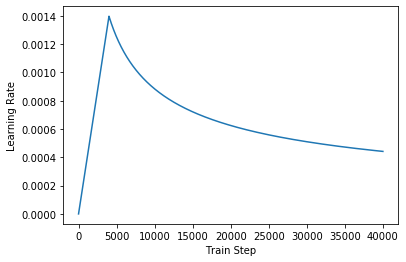

In [38]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 损失和度量

在这里我们使用了遮挡（mask），这样就可以把我们填充的位置的损失置为 0。

In [39]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
    
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)


In [40]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## 训练和检查点

In [41]:
# 构造模型
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [42]:
# 创建检查点
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

目标语句被分成了 **tar_inp** 和 **tar_real**。**tar_inp** 作为输入被传递到解码器。**tar_real** 是位移了 1 的同一个输入：在 **tar_inp** 中的每个位置，**tar_real** 包含了应该被预测到的下一个标记。

例如，目标语句为 “SOS A lion in the jungle is sleeping EOS”，那么：  
tar_inp = “SOS A lion in the jungle is sleeping”  
tar_real = “A lion in the jungle is sleeping EOS”

Transformer 是一个自回归模型：它一次作一个部分的预测，然后使用到目前为止的自身的输出来决定下一步要做什么。

在训练过程中，我们使用了 teacher-forcing 的方法(like in the [text generation tutorial](https://www.tensorflow.org/text/tutorials/text_generation))。无论模型在当前时间步骤下预测出什么，teacher-forcing 方法都会将真实的输出传递到下一个时间步骤上。

当 Transformer 预测每个词时，自注意力（self-attention）功能使它能够查看输入序列中前面的单词，从而更好地预测下一个单词。

In [43]:
EPOCHS = 20
# 该 @tf.function 将追踪-编译 train_step 到 TF 图中，以便更快地
# 执行。该函数专用于参数张量的精确形状。为了避免由于可变序列长度或可变
# 批次大小（最后一批次较小）导致的再追踪，使用 input_signature 指定
# 更多的通用形状。

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [44]:
# 葡萄牙语输入，英语输出
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1 Batch 0 Loss 8.8673 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.7974 Accuracy 0.0076
Epoch 1 Batch 100 Loss 8.6900 Accuracy 0.0299
Epoch 1 Batch 150 Loss 8.5712 Accuracy 0.0403
Epoch 1 Batch 200 Loss 8.4279 Accuracy 0.0454
Epoch 1 Batch 250 Loss 8.2568 Accuracy 0.0495
Epoch 1 Batch 300 Loss 8.0665 Accuracy 0.0543
Epoch 1 Batch 350 Loss 7.8688 Accuracy 0.0593
Epoch 1 Batch 400 Loss 7.6802 Accuracy 0.0651
Epoch 1 Batch 450 Loss 7.5188 Accuracy 0.0719
Epoch 1 Batch 500 Loss 7.3725 Accuracy 0.0788
Epoch 1 Batch 550 Loss 7.2394 Accuracy 0.0858
Epoch 1 Batch 600 Loss 7.1162 Accuracy 0.0931
Epoch 1 Batch 650 Loss 7.0001 Accuracy 0.1002
Epoch 1 Batch 700 Loss 6.8928 Accuracy 0.1066
Ep

## 预测



- 使用葡萄牙语标记器 (tokenizers.pt) 对输入句子进行编码。 这是编码器输入。
- 解码器输入初始化为 [START] 标记。
- 计算padding mask和 look ahead mask。
- 然后解码器通过查看编码器输出和它自己的输出（self-attention）来输出预测。
- 将预测的结果连接到解码器输入，并将其传递给解码器。
- 在这种方法中，解码器根据它预测的之前一个词来预测下一个词。

In [ ]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=20):
    # input sentence is portuguese, hence adding the start and end token
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # as the target is english, the first token to the transformer should be the
    # english start token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a python list) so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)

      # select the last token from the seq_len dimension
      predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.argmax(predictions, axis=-1)

      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # output.shape (1, tokens)
    text = tokenizers.en.detokenize(output)[0]  # shape: ()

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop. So recalculate them outside
    # the loop.
    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens, attention_weights

In [ ]:
translator = Translator(tokenizers, transformer)
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
sentence = "este é um problema que temos que resolver."
ground_truth = "this is a problem we have to solve ."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
sentence = "vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram."
ground_truth = "so i \'ll just share with you some stories very quickly of some magical things that have happened ."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
sentence = "os meus vizinhos ouviram sobre esta ideia."
ground_truth = "and my neighboring homes heard about this idea ."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

## 注意力权重图

Translator 类返回的 attention 字典可以用来可视化模型的内部工作

In [ ]:
sentence = "este é o primeiro livro que eu fiz."
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [ ]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

In [ ]:
translated_tokens

In [ ]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

In [ ]:
plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

In [ ]:
sentence = "Eu li sobre triceratops na enciclopédia."
ground_truth = "I read about triceratops in the encyclopedia."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

## 模型导出

模型预测结果合适，就可以导出模型了 `tf.saved_model`


In [ ]:
# 仅输出了预测结果句子
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result, 
     tokens,
     attention_weights) = self.translator(sentence, max_length=100)

    return result

In [ ]:
translator = ExportTranslator(translator)

In [ ]:
translator("este é o primeiro livro que eu fiz.").numpy()

In [ ]:
tf.saved_model.save(translator, export_dir='translator')

In [ ]:
reloaded = tf.saved_model.load('translator')

In [ ]:
reloaded("este é o primeiro livro que eu fiz.").numpy()